In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [3]:
INPUT_SIZE = 3 # thickness, height, angle
LEARNING_RATE = 0.001
BATCH_SIZE = 32 # 
NUM_EPOCHS = 1000

TEST_SIZE = 0.2
RANDOM_STATE = 42
device = "cpu"

In [4]:
df = pd.read_csv(r'../processed_bending_stiffness.csv')

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates()
removed_count = initial_count - len(df)
if removed_count > 0:
    print(f"Removed {removed_count} duplicate row(s) from the dataset.")
print(f"Shape of dataset after removing duplicates: {df.shape}")
X = df[['Thickness', 'Height', 'Angle (deg)']]
y = df['Bending_Stiffness']

X_train, X_test, y_train, y_test = train_test_split(
    X.values, 
    y.values, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
DATASET_SIZE = len(df) # Number of samples

Removed 685 duplicate row(s) from the dataset.
Shape of dataset after removing duplicates: (743, 4)


In [5]:
train_indices = np.random.choice(len(X_train), 5, replace=False)

print(f"Training Set Random Samples (N={5})")
print("Input Features (Thickness, Height, Angle) | Target (Stiffness)")
print("-" * 75)

for i in train_indices:
    features = X_train[i]
    target = y_train[i]
    print(f"{features} | {target:.4f}")

print("-" * 75)

test_indices = np.random.choice(len(X_test), 5, replace=False)

print(f"Testing Set Random Samples (N={5})")
print("Input Features (Thickness, Height, Angle) | Target (Stiffness)")
print("-" * 75)

for i in test_indices:
    features = X_test[i]
    target = y_test[i]
    print(f"{features} | {target:.4f}")

print("-" * 75)

Training Set Random Samples (N=5)
Input Features (Thickness, Height, Angle) | Target (Stiffness)
---------------------------------------------------------------------------
[ 5.829 60.413 67.3  ] | 4086.0737
[ 8.268 67.694 67.2  ] | 7611.6263
[ 4.766 41.857 68.7  ] | 10.9127
[  7.179 119.738  68.3  ] | 19744.8808
[  3.833 107.508  63.6  ] | 6998.2209
---------------------------------------------------------------------------
Testing Set Random Samples (N=5)
Input Features (Thickness, Height, Angle) | Target (Stiffness)
---------------------------------------------------------------------------
[ 5.456 23.092 63.1  ] | 617.2027
[ 4.647 56.505 47.1  ] | 2627.1173
[ 6.804 61.683 57.4  ] | 4915.3160
[ 5.757 91.656 65.9  ] | 6632.4088
[  3.582 105.265  59.4  ] | 6881.3978
---------------------------------------------------------------------------


In [6]:
model = nn.Sequential(
        nn.Linear(INPUT_SIZE, 64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.2),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        
        # Output Layer
        nn.Linear(16, 1)
).to(device)

In [7]:
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Convert TESTING data to PyTorch Tensors
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32)).unsqueeze(1)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



--- Starting Training ---
Epoch [1/1000], Train Loss (t_loss): 70753433.3468, Val Loss (v_loss): 62736456.6980
Epoch [2/1000], Train Loss (t_loss): 70354694.4108, Val Loss (v_loss): 62120494.1208
Epoch [3/1000], Train Loss (t_loss): 69329316.7003, Val Loss (v_loss): 60564331.8658
Epoch [4/1000], Train Loss (t_loss): 66761690.9091, Val Loss (v_loss): 56947126.4430
Epoch [5/1000], Train Loss (t_loss): 61088419.5286, Val Loss (v_loss): 49565311.7047
Epoch [6/1000], Train Loss (t_loss): 50929307.7441, Val Loss (v_loss): 37854020.5369
Epoch [7/1000], Train Loss (t_loss): 36093419.3636, Val Loss (v_loss): 24368504.4698
Epoch [8/1000], Train Loss (t_loss): 25189266.3165, Val Loss (v_loss): 15293180.1208
Epoch [9/1000], Train Loss (t_loss): 18098335.7946, Val Loss (v_loss): 13330442.4698
Epoch [10/1000], Train Loss (t_loss): 16804826.9731, Val Loss (v_loss): 13122917.6510
Epoch [11/1000], Train Loss (t_loss): 17221586.7744, Val Loss (v_loss): 12890106.1946
Epoch [12/1000], Train Loss (t_loss)

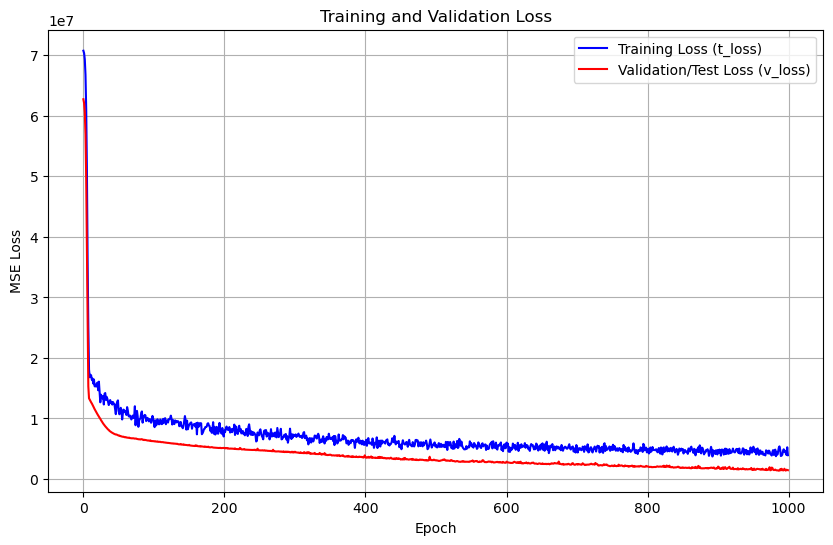


--- Final Evaluation on Test Set ---

Test Set Metrics:
MSE: 1459421.8960
RMSE: 1208.0654
MAE: 784.0856
R-squared (R²): 0.9491

Training and Evaluation complete.


In [8]:
mae_criterion = nn.L1Loss()  # Mean Absolute Error Loss
criterion = nn.MSELoss()  # Mean Squared Error Loss

trainLoss = []
validationLoss = []
print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * targets.size(0)
    
    avg_train_loss = running_loss / len(X_train)
    trainLoss.append(avg_train_loss) # Store the average training loss
    model.eval()
    running_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            val_loss = criterion(outputs, targets) # Use the same loss for comparison
            running_val_loss += val_loss.item() * targets.size(0)
            val_samples += targets.size(0)
    
    avg_val_loss = running_val_loss / val_samples
    validationLoss.append(avg_val_loss) # Store the average validation loss
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss (t_loss): {avg_train_loss:.4f}, Val Loss (v_loss): {avg_val_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(trainLoss, label='Training Loss (t_loss)', color='blue')
plt.plot(validationLoss, label='Validation/Test Loss (v_loss)', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show() #

# --- Final Evaluation on TEST SET ---
print("\n--- Final Evaluation on Test Set ---")
model.eval()
total_squared_error = 0.0
total_absolute_error = 0.0
total_samples = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        # MSE loss
        mse_loss = criterion(outputs, targets)
        total_squared_error += mse_loss.item() * targets.size(0)
        
        # MAE loss
        mae_loss = mae_criterion(outputs, targets)
        total_absolute_error += mae_loss.item() * targets.size(0)
        
        total_samples += targets.size(0)
        all_targets.append(targets.cpu())
        all_predictions.append(outputs.cpu())

# Concatenate all targets and predictions
targets_tensor = torch.cat(all_targets)
predictions_tensor = torch.cat(all_predictions)

# Calculate metrics
mean_squared_error = total_squared_error / total_samples
root_mean_squared_error = np.sqrt(mean_squared_error)
mean_absolute_error = total_absolute_error / total_samples

# R-squared
ss_residual = total_squared_error
target_mean = targets_tensor.mean()
ss_total = ((targets_tensor - target_mean) ** 2).sum().item()
r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else 0.0

print(f'\nTest Set Metrics:')
print(f'MSE: {mean_squared_error:.4f}')
print(f'RMSE: {root_mean_squared_error:.4f}')
print(f'MAE: {mean_absolute_error:.4f}')
print(f'R-squared (R²): {r_squared:.4f}')
print("\nTraining and Evaluation complete.")

In [9]:
torch.save(model.state_dict(), 'model_weight.pth')

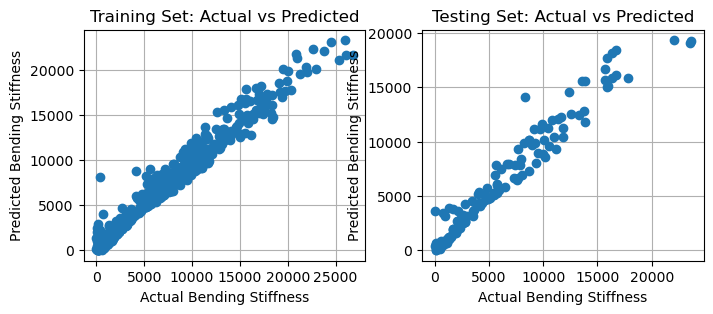

In [10]:

array_y_train_pred = model(X_train_tensor).detach().numpy()
array_y_train = y_train_tensor.detach().numpy()
from matplotlib import pyplot
pyplot.figure(figsize=(8, 3))
pyplot.subplot(1, 2, 1)
pyplot.plot(array_y_train, array_y_train_pred, 'o')
pyplot.xlabel('Actual Bending Stiffness')
pyplot.ylabel('Predicted Bending Stiffness')
pyplot.title('Training Set: Actual vs Predicted')
pyplot.grid("on")
pyplot.subplot(1, 2, 2)
array_y_test_pred = model(X_test_tensor).detach().numpy()
array_y_test = y_test_tensor.detach().numpy()
pyplot.plot(array_y_test, array_y_test_pred, 'o')
pyplot.xlabel('Actual Bending Stiffness')
pyplot.ylabel('Predicted Bending Stiffness')
pyplot.title('Testing Set: Actual vs Predicted')
pyplot.grid("on")
pyplot.show()

In [16]:
print(model(torch.tensor([[4.5134, 76.9252, 62.5199]], dtype=torch.float32)))  # Example bending stiffness input

tensor([[4689.1128]], grad_fn=<AddmmBackward0>)
